### **Mouse Segmentation task assessment**

**Loading required libraries**

In [ ]:
!pip install tensorflow

import numpy as np
import nibabel as nib
import glob
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tifffile import imsave
import tensorflow as tf
import os

from sklearn.preprocessing import MinMaxScaler

**Image Data generator**

In [ ]:
scaler = MinMaxScaler()

def load_img(img_dir, img_list):

    images=[]
    ground_truth_list = []

    for i, image_name in enumerate(img_list):

        if (image_name.split('.')[1] == 'npz'):
            image_file_path = os.path.join(img_dir,image_name)
            npz_object = np.load(image_file_path)
            image = npz_object['arr_0']
            try:
              image=scaler.fit_transform(image.reshape(-1, image.shape[-1])).reshape(image.shape)
              pass
            except Exception as e:
              image=scaler.fit_transform(image.reshape(-1, image.shape[-1])).reshape(image.shape)
              pass
            images.append(image)
            image_ground_truth = npz_object['arr_1'].astype(np.uint8)
            n_classes = 2
            image_ground_truth = to_categorical(image_ground_truth, num_classes=n_classes)
            ground_truth_list.append(image_ground_truth)
            pass
        pass

    images = np.array(images)
    ground_truth_list = np.array(ground_truth_list)

    return(images,ground_truth_list)


def imageLoader(img_dir, img_list, batch_size):

    L = len(img_list)

    #keras needs the generator infinite, so we will use while true
    while True:

        batch_start = 0
        batch_end = batch_size
        while batch_start < L:
            limit = min(batch_end, L)
            X , Y = load_img(img_dir, img_list[batch_start:limit])

            yield (X,Y) #a tuple with two numpy arrays with batch_size samples

            batch_start += batch_size
            batch_end += batch_size
            pass
        pass
    pass

In [ ]:
!unzip dataset.zip

Archive:  dataset.zip
   creating: dataset/
  inflating: dataset/sample-0.npz    
  inflating: dataset/sample-1.npz    
  inflating: dataset/sample-2.npz    
  inflating: dataset/sample-3.npz    
  inflating: dataset/sample-4.npz    
  inflating: dataset/sample-5.npz    
  inflating: dataset/sample-6.npz    
  inflating: dataset/sample-7.npz    
  inflating: dataset/sample-8.npz    
  inflating: dataset/sample-9.npz    


In [ ]:
import random

In [ ]:
dataset_list = sorted(os.listdir('/content/dataset'))

random.seed(42)
random.shuffle(dataset_list)

In [ ]:
training_set = dataset_list[0:8]
validation_set = dataset_list[8:]

In [ ]:
folder_path = '/content/dataset'

train_images_dataGenerator = imageLoader(img_dir=folder_path,img_list=training_set,batch_size=2)
validation_images_dataGenerator = imageLoader(img_dir=folder_path,img_list=validation_set,batch_size=2)

X, Y = validation_images_dataGenerator.__next__()

print(X.shape)
print(Y.shape)

(2, 480, 640, 3)
(2, 480, 640, 2)


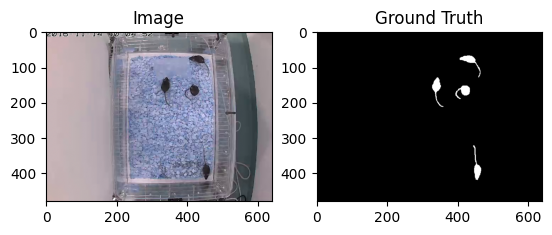

In [ ]:
sample_number = 0

plt.subplot(121)
plt.title('Image')
plt.imshow(X[sample_number])

plt.subplot(122)
plt.title('Ground Truth')
plt.imshow(np.argmax(Y[sample_number],axis=-1),cmap='gray')


plt.show()

**UNET Architecture**

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K

<center><img src="https://miro.medium.com/v2/resize:fit:1400/1*f7YOaE4TWubwaFF7Z1fzNw.png" width=400/></center>

In [ ]:
################################################################
def UNET(n_classes=2, IMG_HEIGHT=480, IMG_WIDTH=640, IMG_CHANNELS=3):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

In [ ]:
unet = UNET()

print(unet.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 480, 640, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 480, 640, 16)         448       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 480, 640, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 480, 640, 16)         2320      ['dropout[0][0]']             
                                                                                              

In [ ]:
from keras import backend as K

**DICE SIMILARITY COEFFICIENT**

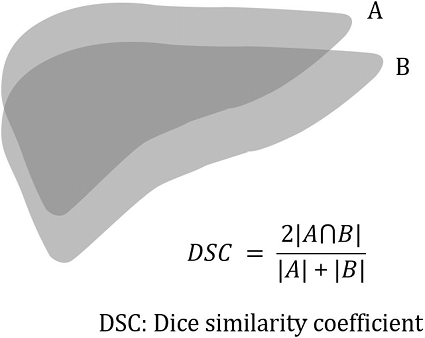

In [ ]:
smooth = 1.

def dice_similarity_coefficient(y_true, y_pred):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_flatten * y_pred_flatten)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_flatten) + tf.reduce_sum(y_pred_flatten) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_similarity_coefficient(y_true, y_pred)

**JACCARD SIMILARITY COEFFICIENT**

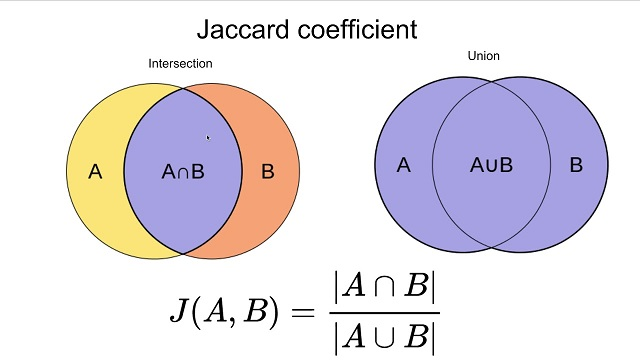

In [ ]:
def jaccard_similarity_coefficient(y_true, y_pred):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    intersection = K.sum(y_true_flatten * y_pred_flatten)
    return (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)

**IOU SCORE**

In [ ]:
!pip install segmentation-models
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

import segmentation_models as sm

IOU_score = sm.metrics.IOUScore(threshold=0.5)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.3 MB/s eta 0:00:00
Segmentation Models: using `tf.keras` framework.


**LOSS FUNCTION**

In [ ]:
import keras
import tensorflow as tf
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU

###########################################################################
#Define loss, metrics and optimizer to be used for training
wt0, wt1 = 0.50, 0.50

############################################# LOSS Functions

#dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1]))
dice_loss = sm.losses.DiceLoss(class_weights=[wt0, wt1])
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

**Batch Size**

In [ ]:
batch_size = 2
steps_per_epoch = len(training_set)//batch_size
validation_steps_per_epoch = len(validation_set)//batch_size

**EVALUATION METRICS**

In [ ]:
metrics = ['accuracy',
           IOU_score,
           jaccard_similarity_coefficient,
           dice_similarity_coefficient,
           ]

**Callbacks function to save training history**

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

# Model Callbacks functions
##########################################################################################
model_file_path = '/content/mouse_segmentation_unet.hdf5'
csv_file_path = '/content/mouse_segmentation_unet_history.csv'

history_logger = tf.keras.callbacks.CSVLogger(filename=csv_file_path,separator=",",append=True)
checkpoint = ModelCheckpoint(model_file_path, monitor="val_loss", save_best_only=False, verbose=2)
##########################################################################################

**Compile and training UNET model**

In [ ]:
loss_function = total_loss

unet_model = UNET(n_classes=2,IMG_HEIGHT=X.shape[1],IMG_WIDTH=X.shape[2],IMG_CHANNELS=X.shape[3])

unet_model.compile(optimizer='adam', loss=loss_function, metrics=metrics)

history=unet_model.fit(train_images_dataGenerator,
          steps_per_epoch=steps_per_epoch,
          epochs=100,
          callbacks=[[history_logger],[checkpoint]],
          verbose=1,
          validation_data=(validation_images_dataGenerator),
          validation_steps=validation_steps_per_epoch,
          )

unet_model.save('/content/mouse_segmentation_unet.hdf5')

Epoch 1/100
4/4 [==============================] - ETA: 0s - loss: 0.7675 - accuracy: 0.9517 - iou_score: 0.4804 - jaccard_similarity_coefficient: 0.7950 - dice_similarity_coefficient: 0.8778
Epoch 1: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 38s 2s/step - loss: 0.7675 - accuracy: 0.9517 - iou_score: 0.4804 - jaccard_similarity_coefficient: 0.7950 - dice_similarity_coefficient: 0.8778 - val_loss: 0.7468 - val_accuracy: 0.9885 - val_iou_score: 0.4943 - val_jaccard_similarity_coefficient: 0.9087 - val_dice_similarity_coefficient: 0.9522
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.7428 - accuracy: 0.9888 - iou_score: 0.4945 - jaccard_similarity_coefficient: 0.9596 - dice_similarity_coefficient: 0.9794
Epoch 2: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 261ms/step - loss: 0.7428 - accuracy: 0.9888 - iou_score: 0.4945 - jaccard_similarity_coefficient: 0.9596 - dice_similarity_coefficient: 0.9794 - val_loss: 0.7403 - val_accuracy: 0.9885 - val_iou_score: 0.4943 - val_jaccard_similarity_coefficient: 0.9387 - val_dice_similarity_coefficient: 0.9684
Epoch 3/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.7360 - accuracy: 0.9888 - iou_score: 0.4944 - jaccard_similarity_coefficient: 0.9547 - dice_similarity_coefficient: 0.9768
Epoch 3: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 284ms/step - loss: 0.7360 - accuracy: 0.9888 - iou_score: 0.4944 - jaccard_similarity_coefficient: 0.9547 - dice_similarity_coefficient: 0.9768 - val_loss: 0.7351 - val_accuracy: 0.9885 - val_iou_score: 0.4943 - val_jaccard_similarity_coefficient: 0.9447 - val_dice_similarity_coefficient: 0.9715
Epoch 4/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.7309 - accuracy: 0.9888 - iou_score: 0.4944 - jaccard_similarity_coefficient: 0.9592 - dice_similarity_coefficient: 0.9792
Epoch 4: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 286ms/step - loss: 0.7309 - accuracy: 0.9888 - iou_score: 0.4944 - jaccard_similarity_coefficient: 0.9592 - dice_similarity_coefficient: 0.9792 - val_loss: 0.7305 - val_accuracy: 0.9885 - val_iou_score: 0.4943 - val_jaccard_similarity_coefficient: 0.9627 - val_dice_similarity_coefficient: 0.9810
Epoch 5/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.7254 - accuracy: 0.9888 - iou_score: 0.4944 - jaccard_similarity_coefficient: 0.9663 - dice_similarity_coefficient: 0.9829
Epoch 5: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 269ms/step - loss: 0.7254 - accuracy: 0.9888 - iou_score: 0.4944 - jaccard_similarity_coefficient: 0.9663 - dice_similarity_coefficient: 0.9829 - val_loss: 0.7283 - val_accuracy: 0.9885 - val_iou_score: 0.4943 - val_jaccard_similarity_coefficient: 0.9642 - val_dice_similarity_coefficient: 0.9818
Epoch 6/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.7142 - accuracy: 0.9888 - iou_score: 0.4944 - jaccard_similarity_coefficient: 0.9677 - dice_similarity_coefficient: 0.9836
Epoch 6: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 255ms/step - loss: 0.7142 - accuracy: 0.9888 - iou_score: 0.4944 - jaccard_similarity_coefficient: 0.9677 - dice_similarity_coefficient: 0.9836 - val_loss: 0.7262 - val_accuracy: 0.9885 - val_iou_score: 0.4943 - val_jaccard_similarity_coefficient: 0.9688 - val_dice_similarity_coefficient: 0.9841
Epoch 7/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.6984 - accuracy: 0.9888 - iou_score: 0.4946 - jaccard_similarity_coefficient: 0.9747 - dice_similarity_coefficient: 0.9872
Epoch 7: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 260ms/step - loss: 0.6984 - accuracy: 0.9888 - iou_score: 0.4946 - jaccard_similarity_coefficient: 0.9747 - dice_similarity_coefficient: 0.9872 - val_loss: 0.6927 - val_accuracy: 0.9885 - val_iou_score: 0.4943 - val_jaccard_similarity_coefficient: 0.9740 - val_dice_similarity_coefficient: 0.9868
Epoch 8/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.6848 - accuracy: 0.9890 - iou_score: 0.5011 - jaccard_similarity_coefficient: 0.9714 - dice_similarity_coefficient: 0.9854
Epoch 8: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 273ms/step - loss: 0.6848 - accuracy: 0.9890 - iou_score: 0.5011 - jaccard_similarity_coefficient: 0.9714 - dice_similarity_coefficient: 0.9854 - val_loss: 0.7035 - val_accuracy: 0.9885 - val_iou_score: 0.4960 - val_jaccard_similarity_coefficient: 0.9767 - val_dice_similarity_coefficient: 0.9882
Epoch 9/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.6566 - accuracy: 0.9898 - iou_score: 0.5474 - jaccard_similarity_coefficient: 0.9780 - dice_similarity_coefficient: 0.9889
Epoch 9: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 286ms/step - loss: 0.6566 - accuracy: 0.9898 - iou_score: 0.5474 - jaccard_similarity_coefficient: 0.9780 - dice_similarity_coefficient: 0.9889 - val_loss: 0.6823 - val_accuracy: 0.9903 - val_iou_score: 0.5782 - val_jaccard_similarity_coefficient: 0.9796 - val_dice_similarity_coefficient: 0.9897
Epoch 10/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.6405 - accuracy: 0.9913 - iou_score: 0.6215 - jaccard_similarity_coefficient: 0.9821 - dice_similarity_coefficient: 0.9910
Epoch 10: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 353ms/step - loss: 0.6405 - accuracy: 0.9913 - iou_score: 0.6215 - jaccard_similarity_coefficient: 0.9821 - dice_similarity_coefficient: 0.9910 - val_loss: 0.6802 - val_accuracy: 0.9913 - val_iou_score: 0.6204 - val_jaccard_similarity_coefficient: 0.9809 - val_dice_similarity_coefficient: 0.9903


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 11/100
4/4 [==============================] - ETA: 0s - loss: 0.6461 - accuracy: 0.9923 - iou_score: 0.6895 - jaccard_similarity_coefficient: 0.9790 - dice_similarity_coefficient: 0.9894
Epoch 11: saving model to /content/mouse_segmentation_unet.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 1s 399ms/step - loss: 0.6461 - accuracy: 0.9923 - iou_score: 0.6895 - jaccard_similarity_coefficient: 0.9790 - dice_similarity_coefficient: 0.9894 - val_loss: 0.6918 - val_accuracy: 0.9910 - val_iou_score: 0.6040 - val_jaccard_similarity_coefficient: 0.9806 - val_dice_similarity_coefficient: 0.9902
Epoch 12/100
4/4 [==============================] - ETA: 0s - loss: 0.6444 - accuracy: 0.9936 - iou_score: 0.7231 - jaccard_similarity_coefficient: 0.9836 - dice_similarity_coefficient: 0.9917
Epoch 12: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 291ms/step - loss: 0.6444 - accuracy: 0.9936 - iou_score: 0.7231 - jaccard_similarity_coefficient: 0.9836 - dice_similarity_coefficient: 0.9917 - val_loss: 0.6358 - val_accuracy: 0.9946 - val_iou_score: 0.7887 - val_jaccard_similarity_coefficient: 0.9811 - val_dice_similarity_coefficient: 0.9904
Epoch 13/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.6621 - accuracy: 0.9851 - iou_score: 0.6986 - jaccard_similarity_coefficient: 0.9622 - dice_similarity_coefficient: 0.9804
Epoch 13: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 286ms/step - loss: 0.6621 - accuracy: 0.9851 - iou_score: 0.6986 - jaccard_similarity_coefficient: 0.9622 - dice_similarity_coefficient: 0.9804 - val_loss: 0.6743 - val_accuracy: 0.9920 - val_iou_score: 0.6483 - val_jaccard_similarity_coefficient: 0.9816 - val_dice_similarity_coefficient: 0.9907
Epoch 14/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.6326 - accuracy: 0.9950 - iou_score: 0.7880 - jaccard_similarity_coefficient: 0.9835 - dice_similarity_coefficient: 0.9917
Epoch 14: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 285ms/step - loss: 0.6326 - accuracy: 0.9950 - iou_score: 0.7880 - jaccard_similarity_coefficient: 0.9835 - dice_similarity_coefficient: 0.9917 - val_loss: 0.6363 - val_accuracy: 0.9945 - val_iou_score: 0.7601 - val_jaccard_similarity_coefficient: 0.9839 - val_dice_similarity_coefficient: 0.9919
Epoch 15/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.6233 - accuracy: 0.9957 - iou_score: 0.8161 - jaccard_similarity_coefficient: 0.9847 - dice_similarity_coefficient: 0.9923
Epoch 15: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 265ms/step - loss: 0.6233 - accuracy: 0.9957 - iou_score: 0.8161 - jaccard_similarity_coefficient: 0.9847 - dice_similarity_coefficient: 0.9923 - val_loss: 0.6342 - val_accuracy: 0.9947 - val_iou_score: 0.7662 - val_jaccard_similarity_coefficient: 0.9843 - val_dice_similarity_coefficient: 0.9921
Epoch 16/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.6222 - accuracy: 0.9955 - iou_score: 0.8150 - jaccard_similarity_coefficient: 0.9845 - dice_similarity_coefficient: 0.9922
Epoch 16: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 286ms/step - loss: 0.6222 - accuracy: 0.9955 - iou_score: 0.8150 - jaccard_similarity_coefficient: 0.9845 - dice_similarity_coefficient: 0.9922 - val_loss: 0.6410 - val_accuracy: 0.9941 - val_iou_score: 0.7416 - val_jaccard_similarity_coefficient: 0.9840 - val_dice_similarity_coefficient: 0.9920
Epoch 17/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.6159 - accuracy: 0.9958 - iou_score: 0.8276 - jaccard_similarity_coefficient: 0.9852 - dice_similarity_coefficient: 0.9925
Epoch 17: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 282ms/step - loss: 0.6159 - accuracy: 0.9958 - iou_score: 0.8276 - jaccard_similarity_coefficient: 0.9852 - dice_similarity_coefficient: 0.9925 - val_loss: 0.6255 - val_accuracy: 0.9951 - val_iou_score: 0.7877 - val_jaccard_similarity_coefficient: 0.9851 - val_dice_similarity_coefficient: 0.9925
Epoch 18/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.6085 - accuracy: 0.9956 - iou_score: 0.8261 - jaccard_similarity_coefficient: 0.9857 - dice_similarity_coefficient: 0.9928
Epoch 18: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 283ms/step - loss: 0.6085 - accuracy: 0.9956 - iou_score: 0.8261 - jaccard_similarity_coefficient: 0.9857 - dice_similarity_coefficient: 0.9928 - val_loss: 0.6195 - val_accuracy: 0.9951 - val_iou_score: 0.7861 - val_jaccard_similarity_coefficient: 0.9857 - val_dice_similarity_coefficient: 0.9928
Epoch 19/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.5842 - accuracy: 0.9953 - iou_score: 0.8223 - jaccard_similarity_coefficient: 0.9876 - dice_similarity_coefficient: 0.9938
Epoch 19: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 281ms/step - loss: 0.5842 - accuracy: 0.9953 - iou_score: 0.8223 - jaccard_similarity_coefficient: 0.9876 - dice_similarity_coefficient: 0.9938 - val_loss: 0.5795 - val_accuracy: 0.9959 - val_iou_score: 0.8228 - val_jaccard_similarity_coefficient: 0.9894 - val_dice_similarity_coefficient: 0.9947
Epoch 20/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.5602 - accuracy: 0.9959 - iou_score: 0.8326 - jaccard_similarity_coefficient: 0.9912 - dice_similarity_coefficient: 0.9956
Epoch 20: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 268ms/step - loss: 0.5602 - accuracy: 0.9959 - iou_score: 0.8326 - jaccard_similarity_coefficient: 0.9912 - dice_similarity_coefficient: 0.9956 - val_loss: 0.5688 - val_accuracy: 0.9956 - val_iou_score: 0.8094 - val_jaccard_similarity_coefficient: 0.9908 - val_dice_similarity_coefficient: 0.9954
Epoch 21/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.5553 - accuracy: 0.9959 - iou_score: 0.8355 - jaccard_similarity_coefficient: 0.9918 - dice_similarity_coefficient: 0.9959
Epoch 21: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 262ms/step - loss: 0.5553 - accuracy: 0.9959 - iou_score: 0.8355 - jaccard_similarity_coefficient: 0.9918 - dice_similarity_coefficient: 0.9959 - val_loss: 0.5691 - val_accuracy: 0.9955 - val_iou_score: 0.8031 - val_jaccard_similarity_coefficient: 0.9909 - val_dice_similarity_coefficient: 0.9954
Epoch 22/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.5511 - accuracy: 0.9964 - iou_score: 0.8465 - jaccard_similarity_coefficient: 0.9927 - dice_similarity_coefficient: 0.9964
Epoch 22: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 301ms/step - loss: 0.5511 - accuracy: 0.9964 - iou_score: 0.8465 - jaccard_similarity_coefficient: 0.9927 - dice_similarity_coefficient: 0.9964 - val_loss: 0.5608 - val_accuracy: 0.9959 - val_iou_score: 0.8225 - val_jaccard_similarity_coefficient: 0.9918 - val_dice_similarity_coefficient: 0.9959


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 23/100
4/4 [==============================] - ETA: 0s - loss: 0.5498 - accuracy: 0.9965 - iou_score: 0.8502 - jaccard_similarity_coefficient: 0.9930 - dice_similarity_coefficient: 0.9965
Epoch 23: saving model to /content/mouse_segmentation_unet.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 1s 419ms/step - loss: 0.5498 - accuracy: 0.9965 - iou_score: 0.8502 - jaccard_similarity_coefficient: 0.9930 - dice_similarity_coefficient: 0.9965 - val_loss: 0.5509 - val_accuracy: 0.9964 - val_iou_score: 0.8474 - val_jaccard_similarity_coefficient: 0.9929 - val_dice_similarity_coefficient: 0.9964
Epoch 24/100
4/4 [==============================] - ETA: 0s - loss: 0.5531 - accuracy: 0.9963 - iou_score: 0.8416 - jaccard_similarity_coefficient: 0.9925 - dice_similarity_coefficient: 0.9963
Epoch 24: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 330ms/step - loss: 0.5531 - accuracy: 0.9963 - iou_score: 0.8416 - jaccard_similarity_coefficient: 0.9925 - dice_similarity_coefficient: 0.9963 - val_loss: 0.5547 - val_accuracy: 0.9963 - val_iou_score: 0.8382 - val_jaccard_similarity_coefficient: 0.9925 - val_dice_similarity_coefficient: 0.9962
Epoch 25/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.5503 - accuracy: 0.9963 - iou_score: 0.8494 - jaccard_similarity_coefficient: 0.9927 - dice_similarity_coefficient: 0.9963
Epoch 25: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 289ms/step - loss: 0.5503 - accuracy: 0.9963 - iou_score: 0.8494 - jaccard_similarity_coefficient: 0.9927 - dice_similarity_coefficient: 0.9963 - val_loss: 0.5617 - val_accuracy: 0.9959 - val_iou_score: 0.8204 - val_jaccard_similarity_coefficient: 0.9917 - val_dice_similarity_coefficient: 0.9959
Epoch 26/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.5499 - accuracy: 0.9966 - iou_score: 0.8499 - jaccard_similarity_coefficient: 0.9931 - dice_similarity_coefficient: 0.9965
Epoch 26: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 282ms/step - loss: 0.5499 - accuracy: 0.9966 - iou_score: 0.8499 - jaccard_similarity_coefficient: 0.9931 - dice_similarity_coefficient: 0.9965 - val_loss: 0.5503 - val_accuracy: 0.9965 - val_iou_score: 0.8489 - val_jaccard_similarity_coefficient: 0.9929 - val_dice_similarity_coefficient: 0.9964
Epoch 27/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.5499 - accuracy: 0.9964 - iou_score: 0.8501 - jaccard_similarity_coefficient: 0.9928 - dice_similarity_coefficient: 0.9964
Epoch 27: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 279ms/step - loss: 0.5499 - accuracy: 0.9964 - iou_score: 0.8501 - jaccard_similarity_coefficient: 0.9928 - dice_similarity_coefficient: 0.9964 - val_loss: 0.5597 - val_accuracy: 0.9960 - val_iou_score: 0.8247 - val_jaccard_similarity_coefficient: 0.9920 - val_dice_similarity_coefficient: 0.9960
Epoch 28/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.5477 - accuracy: 0.9967 - iou_score: 0.8558 - jaccard_similarity_coefficient: 0.9933 - dice_similarity_coefficient: 0.9966
Epoch 28: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 260ms/step - loss: 0.5477 - accuracy: 0.9967 - iou_score: 0.8558 - jaccard_similarity_coefficient: 0.9933 - dice_similarity_coefficient: 0.9966 - val_loss: 0.5490 - val_accuracy: 0.9966 - val_iou_score: 0.8523 - val_jaccard_similarity_coefficient: 0.9931 - val_dice_similarity_coefficient: 0.9965
Epoch 29/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.5497 - accuracy: 0.9965 - iou_score: 0.8507 - jaccard_similarity_coefficient: 0.9929 - dice_similarity_coefficient: 0.9964
Epoch 29: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 282ms/step - loss: 0.5497 - accuracy: 0.9965 - iou_score: 0.8507 - jaccard_similarity_coefficient: 0.9929 - dice_similarity_coefficient: 0.9964 - val_loss: 0.5616 - val_accuracy: 0.9959 - val_iou_score: 0.8203 - val_jaccard_similarity_coefficient: 0.9918 - val_dice_similarity_coefficient: 0.9959
Epoch 30/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.5478 - accuracy: 0.9966 - iou_score: 0.8557 - jaccard_similarity_coefficient: 0.9932 - dice_similarity_coefficient: 0.9966
Epoch 30: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 289ms/step - loss: 0.5478 - accuracy: 0.9966 - iou_score: 0.8557 - jaccard_similarity_coefficient: 0.9932 - dice_similarity_coefficient: 0.9966 - val_loss: 0.5505 - val_accuracy: 0.9965 - val_iou_score: 0.8486 - val_jaccard_similarity_coefficient: 0.9929 - val_dice_similarity_coefficient: 0.9964
Epoch 31/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.5470 - accuracy: 0.9967 - iou_score: 0.8580 - jaccard_similarity_coefficient: 0.9934 - dice_similarity_coefficient: 0.9967
Epoch 31: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 287ms/step - loss: 0.5470 - accuracy: 0.9967 - iou_score: 0.8580 - jaccard_similarity_coefficient: 0.9934 - dice_similarity_coefficient: 0.9967 - val_loss: 0.5581 - val_accuracy: 0.9961 - val_iou_score: 0.8286 - val_jaccard_similarity_coefficient: 0.9921 - val_dice_similarity_coefficient: 0.9960
Epoch 32/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.5462 - accuracy: 0.9967 - iou_score: 0.8597 - jaccard_similarity_coefficient: 0.9935 - dice_similarity_coefficient: 0.9967
Epoch 32: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 272ms/step - loss: 0.5462 - accuracy: 0.9967 - iou_score: 0.8597 - jaccard_similarity_coefficient: 0.9935 - dice_similarity_coefficient: 0.9967 - val_loss: 0.5498 - val_accuracy: 0.9965 - val_iou_score: 0.8503 - val_jaccard_similarity_coefficient: 0.9930 - val_dice_similarity_coefficient: 0.9965
Epoch 33/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.5462 - accuracy: 0.9967 - iou_score: 0.8594 - jaccard_similarity_coefficient: 0.9934 - dice_similarity_coefficient: 0.9967
Epoch 33: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 282ms/step - loss: 0.5462 - accuracy: 0.9967 - iou_score: 0.8594 - jaccard_similarity_coefficient: 0.9934 - dice_similarity_coefficient: 0.9967 - val_loss: 0.5528 - val_accuracy: 0.9964 - val_iou_score: 0.8427 - val_jaccard_similarity_coefficient: 0.9927 - val_dice_similarity_coefficient: 0.9963
Epoch 34/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.5452 - accuracy: 0.9968 - iou_score: 0.8621 - jaccard_similarity_coefficient: 0.9935 - dice_similarity_coefficient: 0.9967
Epoch 34: saving model to /content/mouse_segmentation_unet.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 1s 311ms/step - loss: 0.5452 - accuracy: 0.9968 - iou_score: 0.8621 - jaccard_similarity_coefficient: 0.9935 - dice_similarity_coefficient: 0.9967 - val_loss: 0.5532 - val_accuracy: 0.9963 - val_iou_score: 0.8410 - val_jaccard_similarity_coefficient: 0.9926 - val_dice_similarity_coefficient: 0.9963
Epoch 35/100
4/4 [==============================] - ETA: 0s - loss: 0.5439 - accuracy: 0.9969 - iou_score: 0.8654 - jaccard_similarity_coefficient: 0.9937 - dice_similarity_coefficient: 0.9969
Epoch 35: saving model to /content/mouse_segmentation_unet.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 1s 416ms/step - loss: 0.5439 - accuracy: 0.9969 - iou_score: 0.8654 - jaccard_similarity_coefficient: 0.9937 - dice_similarity_coefficient: 0.9969 - val_loss: 0.5507 - val_accuracy: 0.9965 - val_iou_score: 0.8478 - val_jaccard_similarity_coefficient: 0.9929 - val_dice_similarity_coefficient: 0.9964
Epoch 36/100
4/4 [==============================] - ETA: 0s - loss: 0.5458 - accuracy: 0.9967 - iou_score: 0.8596 - jaccard_similarity_coefficient: 0.9933 - dice_similarity_coefficient: 0.9966
Epoch 36: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 358ms/step - loss: 0.5458 - accuracy: 0.9967 - iou_score: 0.8596 - jaccard_similarity_coefficient: 0.9933 - dice_similarity_coefficient: 0.9966 - val_loss: 0.5634 - val_accuracy: 0.9958 - val_iou_score: 0.8153 - val_jaccard_similarity_coefficient: 0.9915 - val_dice_similarity_coefficient: 0.9957
Epoch 37/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.5456 - accuracy: 0.9968 - iou_score: 0.8609 - jaccard_similarity_coefficient: 0.9935 - dice_similarity_coefficient: 0.9967
Epoch 37: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 266ms/step - loss: 0.5456 - accuracy: 0.9968 - iou_score: 0.8609 - jaccard_similarity_coefficient: 0.9935 - dice_similarity_coefficient: 0.9967 - val_loss: 0.5552 - val_accuracy: 0.9962 - val_iou_score: 0.8359 - val_jaccard_similarity_coefficient: 0.9924 - val_dice_similarity_coefficient: 0.9962
Epoch 38/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.5453 - accuracy: 0.9968 - iou_score: 0.8617 - jaccard_similarity_coefficient: 0.9936 - dice_similarity_coefficient: 0.9968
Epoch 38: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 283ms/step - loss: 0.5453 - accuracy: 0.9968 - iou_score: 0.8617 - jaccard_similarity_coefficient: 0.9936 - dice_similarity_coefficient: 0.9968 - val_loss: 0.5520 - val_accuracy: 0.9964 - val_iou_score: 0.8435 - val_jaccard_similarity_coefficient: 0.9927 - val_dice_similarity_coefficient: 0.9963
Epoch 39/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.5454 - accuracy: 0.9967 - iou_score: 0.8609 - jaccard_similarity_coefficient: 0.9933 - dice_similarity_coefficient: 0.9967
Epoch 39: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 291ms/step - loss: 0.5454 - accuracy: 0.9967 - iou_score: 0.8609 - jaccard_similarity_coefficient: 0.9933 - dice_similarity_coefficient: 0.9967 - val_loss: 0.5556 - val_accuracy: 0.9962 - val_iou_score: 0.8327 - val_jaccard_similarity_coefficient: 0.9923 - val_dice_similarity_coefficient: 0.9961
Epoch 40/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.5428 - accuracy: 0.9969 - iou_score: 0.8679 - jaccard_similarity_coefficient: 0.9937 - dice_similarity_coefficient: 0.9969
Epoch 40: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 266ms/step - loss: 0.5428 - accuracy: 0.9969 - iou_score: 0.8679 - jaccard_similarity_coefficient: 0.9937 - dice_similarity_coefficient: 0.9969 - val_loss: 0.5524 - val_accuracy: 0.9964 - val_iou_score: 0.8421 - val_jaccard_similarity_coefficient: 0.9926 - val_dice_similarity_coefficient: 0.9963
Epoch 41/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.5408 - accuracy: 0.9970 - iou_score: 0.8724 - jaccard_similarity_coefficient: 0.9939 - dice_similarity_coefficient: 0.9970
Epoch 41: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 288ms/step - loss: 0.5408 - accuracy: 0.9970 - iou_score: 0.8724 - jaccard_similarity_coefficient: 0.9939 - dice_similarity_coefficient: 0.9970 - val_loss: 0.5545 - val_accuracy: 0.9962 - val_iou_score: 0.8371 - val_jaccard_similarity_coefficient: 0.9924 - val_dice_similarity_coefficient: 0.9962
Epoch 42/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.5404 - accuracy: 0.9970 - iou_score: 0.8743 - jaccard_similarity_coefficient: 0.9940 - dice_similarity_coefficient: 0.9970
Epoch 42: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 270ms/step - loss: 0.5404 - accuracy: 0.9970 - iou_score: 0.8743 - jaccard_similarity_coefficient: 0.9940 - dice_similarity_coefficient: 0.9970 - val_loss: 0.5546 - val_accuracy: 0.9962 - val_iou_score: 0.8370 - val_jaccard_similarity_coefficient: 0.9924 - val_dice_similarity_coefficient: 0.9962
Epoch 43/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.5387 - accuracy: 0.9971 - iou_score: 0.8781 - jaccard_similarity_coefficient: 0.9941 - dice_similarity_coefficient: 0.9971
Epoch 43: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 283ms/step - loss: 0.5387 - accuracy: 0.9971 - iou_score: 0.8781 - jaccard_similarity_coefficient: 0.9941 - dice_similarity_coefficient: 0.9971 - val_loss: 0.5776 - val_accuracy: 0.9950 - val_iou_score: 0.7824 - val_jaccard_similarity_coefficient: 0.9899 - val_dice_similarity_coefficient: 0.9949
Epoch 44/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.5485 - accuracy: 0.9963 - iou_score: 0.8517 - jaccard_similarity_coefficient: 0.9926 - dice_similarity_coefficient: 0.9963
Epoch 44: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 259ms/step - loss: 0.5485 - accuracy: 0.9963 - iou_score: 0.8517 - jaccard_similarity_coefficient: 0.9926 - dice_similarity_coefficient: 0.9963 - val_loss: 0.5673 - val_accuracy: 0.9956 - val_iou_score: 0.8060 - val_jaccard_similarity_coefficient: 0.9911 - val_dice_similarity_coefficient: 0.9955
Epoch 45/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.5488 - accuracy: 0.9965 - iou_score: 0.8530 - jaccard_similarity_coefficient: 0.9929 - dice_similarity_coefficient: 0.9965
Epoch 45: saving model to /content/mouse_segmentation_unet.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 1s 421ms/step - loss: 0.5488 - accuracy: 0.9965 - iou_score: 0.8530 - jaccard_similarity_coefficient: 0.9929 - dice_similarity_coefficient: 0.9965 - val_loss: 0.5742 - val_accuracy: 0.9952 - val_iou_score: 0.7892 - val_jaccard_similarity_coefficient: 0.9904 - val_dice_similarity_coefficient: 0.9952
Epoch 46/100
4/4 [==============================] - ETA: 0s - loss: 0.5479 - accuracy: 0.9967 - iou_score: 0.8556 - jaccard_similarity_coefficient: 0.9934 - dice_similarity_coefficient: 0.9967
Epoch 46: saving model to /content/mouse_segmentation_unet.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 1s 306ms/step - loss: 0.5479 - accuracy: 0.9967 - iou_score: 0.8556 - jaccard_similarity_coefficient: 0.9934 - dice_similarity_coefficient: 0.9967 - val_loss: 0.5576 - val_accuracy: 0.9961 - val_iou_score: 0.8304 - val_jaccard_similarity_coefficient: 0.9922 - val_dice_similarity_coefficient: 0.9961
Epoch 47/100
4/4 [==============================] - ETA: 0s - loss: 0.5497 - accuracy: 0.9964 - iou_score: 0.8509 - jaccard_similarity_coefficient: 0.9929 - dice_similarity_coefficient: 0.9964
Epoch 47: saving model to /content/mouse_segmentation_unet.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 1s 434ms/step - loss: 0.5497 - accuracy: 0.9964 - iou_score: 0.8509 - jaccard_similarity_coefficient: 0.9929 - dice_similarity_coefficient: 0.9964 - val_loss: 0.5742 - val_accuracy: 0.9952 - val_iou_score: 0.7903 - val_jaccard_similarity_coefficient: 0.9904 - val_dice_similarity_coefficient: 0.9952
Epoch 48/100
4/4 [==============================] - ETA: 0s - loss: 0.5460 - accuracy: 0.9968 - iou_score: 0.8602 - jaccard_similarity_coefficient: 0.9935 - dice_similarity_coefficient: 0.9968
Epoch 48: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 357ms/step - loss: 0.5460 - accuracy: 0.9968 - iou_score: 0.8602 - jaccard_similarity_coefficient: 0.9935 - dice_similarity_coefficient: 0.9968 - val_loss: 0.5576 - val_accuracy: 0.9961 - val_iou_score: 0.8302 - val_jaccard_similarity_coefficient: 0.9922 - val_dice_similarity_coefficient: 0.9961
Epoch 49/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.5465 - accuracy: 0.9967 - iou_score: 0.8592 - jaccard_similarity_coefficient: 0.9934 - dice_similarity_coefficient: 0.9967
Epoch 49: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 286ms/step - loss: 0.5465 - accuracy: 0.9967 - iou_score: 0.8592 - jaccard_similarity_coefficient: 0.9934 - dice_similarity_coefficient: 0.9967 - val_loss: 0.5691 - val_accuracy: 0.9955 - val_iou_score: 0.8019 - val_jaccard_similarity_coefficient: 0.9909 - val_dice_similarity_coefficient: 0.9955
Epoch 50/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.5452 - accuracy: 0.9968 - iou_score: 0.8624 - jaccard_similarity_coefficient: 0.9936 - dice_similarity_coefficient: 0.9968
Epoch 50: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 285ms/step - loss: 0.5452 - accuracy: 0.9968 - iou_score: 0.8624 - jaccard_similarity_coefficient: 0.9936 - dice_similarity_coefficient: 0.9968 - val_loss: 0.5642 - val_accuracy: 0.9957 - val_iou_score: 0.8133 - val_jaccard_similarity_coefficient: 0.9915 - val_dice_similarity_coefficient: 0.9957
Epoch 51/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.5451 - accuracy: 0.9968 - iou_score: 0.8628 - jaccard_similarity_coefficient: 0.9937 - dice_similarity_coefficient: 0.9968
Epoch 51: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 285ms/step - loss: 0.5451 - accuracy: 0.9968 - iou_score: 0.8628 - jaccard_similarity_coefficient: 0.9937 - dice_similarity_coefficient: 0.9968 - val_loss: 0.5603 - val_accuracy: 0.9960 - val_iou_score: 0.8236 - val_jaccard_similarity_coefficient: 0.9919 - val_dice_similarity_coefficient: 0.9959
Epoch 52/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.5449 - accuracy: 0.9968 - iou_score: 0.8629 - jaccard_similarity_coefficient: 0.9936 - dice_similarity_coefficient: 0.9968
Epoch 52: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 270ms/step - loss: 0.5449 - accuracy: 0.9968 - iou_score: 0.8629 - jaccard_similarity_coefficient: 0.9936 - dice_similarity_coefficient: 0.9968 - val_loss: 0.5598 - val_accuracy: 0.9960 - val_iou_score: 0.8254 - val_jaccard_similarity_coefficient: 0.9919 - val_dice_similarity_coefficient: 0.9959
Epoch 53/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.5448 - accuracy: 0.9969 - iou_score: 0.8635 - jaccard_similarity_coefficient: 0.9937 - dice_similarity_coefficient: 0.9968
Epoch 53: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 292ms/step - loss: 0.5448 - accuracy: 0.9969 - iou_score: 0.8635 - jaccard_similarity_coefficient: 0.9937 - dice_similarity_coefficient: 0.9968 - val_loss: 0.5593 - val_accuracy: 0.9960 - val_iou_score: 0.8268 - val_jaccard_similarity_coefficient: 0.9919 - val_dice_similarity_coefficient: 0.9960
Epoch 54/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.5443 - accuracy: 0.9968 - iou_score: 0.8646 - jaccard_similarity_coefficient: 0.9937 - dice_similarity_coefficient: 0.9968
Epoch 54: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 277ms/step - loss: 0.5443 - accuracy: 0.9968 - iou_score: 0.8646 - jaccard_similarity_coefficient: 0.9937 - dice_similarity_coefficient: 0.9968 - val_loss: 0.5633 - val_accuracy: 0.9958 - val_iou_score: 0.8162 - val_jaccard_similarity_coefficient: 0.9915 - val_dice_similarity_coefficient: 0.9957
Epoch 55/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.5438 - accuracy: 0.9969 - iou_score: 0.8664 - jaccard_similarity_coefficient: 0.9938 - dice_similarity_coefficient: 0.9969
Epoch 55: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 291ms/step - loss: 0.5438 - accuracy: 0.9969 - iou_score: 0.8664 - jaccard_similarity_coefficient: 0.9938 - dice_similarity_coefficient: 0.9969 - val_loss: 0.5577 - val_accuracy: 0.9961 - val_iou_score: 0.8312 - val_jaccard_similarity_coefficient: 0.9921 - val_dice_similarity_coefficient: 0.9960
Epoch 56/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.5435 - accuracy: 0.9969 - iou_score: 0.8666 - jaccard_similarity_coefficient: 0.9938 - dice_similarity_coefficient: 0.9969
Epoch 56: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 295ms/step - loss: 0.5435 - accuracy: 0.9969 - iou_score: 0.8666 - jaccard_similarity_coefficient: 0.9938 - dice_similarity_coefficient: 0.9969 - val_loss: 0.5644 - val_accuracy: 0.9958 - val_iou_score: 0.8144 - val_jaccard_similarity_coefficient: 0.9913 - val_dice_similarity_coefficient: 0.9956
Epoch 57/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.5427 - accuracy: 0.9970 - iou_score: 0.8688 - jaccard_similarity_coefficient: 0.9939 - dice_similarity_coefficient: 0.9970
Epoch 57: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 288ms/step - loss: 0.5427 - accuracy: 0.9970 - iou_score: 0.8688 - jaccard_similarity_coefficient: 0.9939 - dice_similarity_coefficient: 0.9970 - val_loss: 0.5562 - val_accuracy: 0.9962 - val_iou_score: 0.8334 - val_jaccard_similarity_coefficient: 0.9922 - val_dice_similarity_coefficient: 0.9961
Epoch 58/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.5423 - accuracy: 0.9970 - iou_score: 0.8693 - jaccard_similarity_coefficient: 0.9939 - dice_similarity_coefficient: 0.9969
Epoch 58: saving model to /content/mouse_segmentation_unet.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 1s 295ms/step - loss: 0.5423 - accuracy: 0.9970 - iou_score: 0.8693 - jaccard_similarity_coefficient: 0.9939 - dice_similarity_coefficient: 0.9969 - val_loss: 0.5584 - val_accuracy: 0.9960 - val_iou_score: 0.8268 - val_jaccard_similarity_coefficient: 0.9919 - val_dice_similarity_coefficient: 0.9959
Epoch 59/100
4/4 [==============================] - ETA: 0s - loss: 0.5384 - accuracy: 0.9971 - iou_score: 0.8788 - jaccard_similarity_coefficient: 0.9942 - dice_similarity_coefficient: 0.9971
Epoch 59: saving model to /content/mouse_segmentation_unet.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 1s 420ms/step - loss: 0.5384 - accuracy: 0.9971 - iou_score: 0.8788 - jaccard_similarity_coefficient: 0.9942 - dice_similarity_coefficient: 0.9971 - val_loss: 0.5681 - val_accuracy: 0.9956 - val_iou_score: 0.8069 - val_jaccard_similarity_coefficient: 0.9907 - val_dice_similarity_coefficient: 0.9953
Epoch 60/100
4/4 [==============================] - ETA: 0s - loss: 0.5421 - accuracy: 0.9970 - iou_score: 0.8701 - jaccard_similarity_coefficient: 0.9938 - dice_similarity_coefficient: 0.9969
Epoch 60: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 337ms/step - loss: 0.5421 - accuracy: 0.9970 - iou_score: 0.8701 - jaccard_similarity_coefficient: 0.9938 - dice_similarity_coefficient: 0.9969 - val_loss: 0.5435 - val_accuracy: 0.9970 - val_iou_score: 0.8705 - val_jaccard_similarity_coefficient: 0.9935 - val_dice_similarity_coefficient: 0.9967
Epoch 61/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.5394 - accuracy: 0.9970 - iou_score: 0.8759 - jaccard_similarity_coefficient: 0.9940 - dice_similarity_coefficient: 0.9970
Epoch 61: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 277ms/step - loss: 0.5394 - accuracy: 0.9970 - iou_score: 0.8759 - jaccard_similarity_coefficient: 0.9940 - dice_similarity_coefficient: 0.9970 - val_loss: 0.5552 - val_accuracy: 0.9962 - val_iou_score: 0.8350 - val_jaccard_similarity_coefficient: 0.9922 - val_dice_similarity_coefficient: 0.9961
Epoch 62/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.5375 - accuracy: 0.9972 - iou_score: 0.8816 - jaccard_similarity_coefficient: 0.9944 - dice_similarity_coefficient: 0.9972
Epoch 62: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 265ms/step - loss: 0.5375 - accuracy: 0.9972 - iou_score: 0.8816 - jaccard_similarity_coefficient: 0.9944 - dice_similarity_coefficient: 0.9972 - val_loss: 0.5510 - val_accuracy: 0.9964 - val_iou_score: 0.8452 - val_jaccard_similarity_coefficient: 0.9927 - val_dice_similarity_coefficient: 0.9963
Epoch 63/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.5368 - accuracy: 0.9972 - iou_score: 0.8828 - jaccard_similarity_coefficient: 0.9944 - dice_similarity_coefficient: 0.9972
Epoch 63: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 269ms/step - loss: 0.5368 - accuracy: 0.9972 - iou_score: 0.8828 - jaccard_similarity_coefficient: 0.9944 - dice_similarity_coefficient: 0.9972 - val_loss: 0.5533 - val_accuracy: 0.9963 - val_iou_score: 0.8391 - val_jaccard_similarity_coefficient: 0.9924 - val_dice_similarity_coefficient: 0.9962
Epoch 64/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.5347 - accuracy: 0.9974 - iou_score: 0.8895 - jaccard_similarity_coefficient: 0.9947 - dice_similarity_coefficient: 0.9974
Epoch 64: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 293ms/step - loss: 0.5347 - accuracy: 0.9974 - iou_score: 0.8895 - jaccard_similarity_coefficient: 0.9947 - dice_similarity_coefficient: 0.9974 - val_loss: 0.5517 - val_accuracy: 0.9964 - val_iou_score: 0.8434 - val_jaccard_similarity_coefficient: 0.9925 - val_dice_similarity_coefficient: 0.9962
Epoch 65/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.5343 - accuracy: 0.9974 - iou_score: 0.8900 - jaccard_similarity_coefficient: 0.9946 - dice_similarity_coefficient: 0.9973
Epoch 65: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 267ms/step - loss: 0.5343 - accuracy: 0.9974 - iou_score: 0.8900 - jaccard_similarity_coefficient: 0.9946 - dice_similarity_coefficient: 0.9973 - val_loss: 0.5563 - val_accuracy: 0.9962 - val_iou_score: 0.8327 - val_jaccard_similarity_coefficient: 0.9920 - val_dice_similarity_coefficient: 0.9960
Epoch 66/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.5339 - accuracy: 0.9974 - iou_score: 0.8913 - jaccard_similarity_coefficient: 0.9947 - dice_similarity_coefficient: 0.9974
Epoch 66: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 272ms/step - loss: 0.5339 - accuracy: 0.9974 - iou_score: 0.8913 - jaccard_similarity_coefficient: 0.9947 - dice_similarity_coefficient: 0.9974 - val_loss: 0.5586 - val_accuracy: 0.9960 - val_iou_score: 0.8265 - val_jaccard_similarity_coefficient: 0.9917 - val_dice_similarity_coefficient: 0.9959
Epoch 67/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.5331 - accuracy: 0.9975 - iou_score: 0.8934 - jaccard_similarity_coefficient: 0.9949 - dice_similarity_coefficient: 0.9974
Epoch 67: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 273ms/step - loss: 0.5331 - accuracy: 0.9975 - iou_score: 0.8934 - jaccard_similarity_coefficient: 0.9949 - dice_similarity_coefficient: 0.9974 - val_loss: 0.5424 - val_accuracy: 0.9969 - val_iou_score: 0.8689 - val_jaccard_similarity_coefficient: 0.9935 - val_dice_similarity_coefficient: 0.9967
Epoch 68/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.5335 - accuracy: 0.9974 - iou_score: 0.8917 - jaccard_similarity_coefficient: 0.9947 - dice_similarity_coefficient: 0.9974
Epoch 68: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 285ms/step - loss: 0.5335 - accuracy: 0.9974 - iou_score: 0.8917 - jaccard_similarity_coefficient: 0.9947 - dice_similarity_coefficient: 0.9974 - val_loss: 0.5560 - val_accuracy: 0.9961 - val_iou_score: 0.8317 - val_jaccard_similarity_coefficient: 0.9920 - val_dice_similarity_coefficient: 0.9960
Epoch 69/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.5322 - accuracy: 0.9975 - iou_score: 0.8963 - jaccard_similarity_coefficient: 0.9950 - dice_similarity_coefficient: 0.9975
Epoch 69: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 258ms/step - loss: 0.5322 - accuracy: 0.9975 - iou_score: 0.8963 - jaccard_similarity_coefficient: 0.9950 - dice_similarity_coefficient: 0.9975 - val_loss: 0.5553 - val_accuracy: 0.9961 - val_iou_score: 0.8336 - val_jaccard_similarity_coefficient: 0.9921 - val_dice_similarity_coefficient: 0.9961
Epoch 70/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.5313 - accuracy: 0.9976 - iou_score: 0.8991 - jaccard_similarity_coefficient: 0.9952 - dice_similarity_coefficient: 0.9976
Epoch 70: saving model to /content/mouse_segmentation_unet.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 1s 417ms/step - loss: 0.5313 - accuracy: 0.9976 - iou_score: 0.8991 - jaccard_similarity_coefficient: 0.9952 - dice_similarity_coefficient: 0.9976 - val_loss: 0.5514 - val_accuracy: 0.9964 - val_iou_score: 0.8442 - val_jaccard_similarity_coefficient: 0.9926 - val_dice_similarity_coefficient: 0.9963
Epoch 71/100
4/4 [==============================] - ETA: 0s - loss: 0.5309 - accuracy: 0.9976 - iou_score: 0.9001 - jaccard_similarity_coefficient: 0.9952 - dice_similarity_coefficient: 0.9976
Epoch 71: saving model to /content/mouse_segmentation_unet.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 1s 422ms/step - loss: 0.5309 - accuracy: 0.9976 - iou_score: 0.9001 - jaccard_similarity_coefficient: 0.9952 - dice_similarity_coefficient: 0.9976 - val_loss: 0.5631 - val_accuracy: 0.9957 - val_iou_score: 0.8138 - val_jaccard_similarity_coefficient: 0.9913 - val_dice_similarity_coefficient: 0.9956
Epoch 72/100
4/4 [==============================] - ETA: 0s - loss: 0.5308 - accuracy: 0.9976 - iou_score: 0.9004 - jaccard_similarity_coefficient: 0.9952 - dice_similarity_coefficient: 0.9976
Epoch 72: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 408ms/step - loss: 0.5308 - accuracy: 0.9976 - iou_score: 0.9004 - jaccard_similarity_coefficient: 0.9952 - dice_similarity_coefficient: 0.9976 - val_loss: 0.5498 - val_accuracy: 0.9965 - val_iou_score: 0.8487 - val_jaccard_similarity_coefficient: 0.9928 - val_dice_similarity_coefficient: 0.9964
Epoch 73/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.5304 - accuracy: 0.9977 - iou_score: 0.9016 - jaccard_similarity_coefficient: 0.9953 - dice_similarity_coefficient: 0.9977
Epoch 73: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 262ms/step - loss: 0.5304 - accuracy: 0.9977 - iou_score: 0.9016 - jaccard_similarity_coefficient: 0.9953 - dice_similarity_coefficient: 0.9977 - val_loss: 0.5483 - val_accuracy: 0.9965 - val_iou_score: 0.8513 - val_jaccard_similarity_coefficient: 0.9930 - val_dice_similarity_coefficient: 0.9965
Epoch 74/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.5295 - accuracy: 0.9977 - iou_score: 0.9041 - jaccard_similarity_coefficient: 0.9954 - dice_similarity_coefficient: 0.9977
Epoch 74: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 271ms/step - loss: 0.5295 - accuracy: 0.9977 - iou_score: 0.9041 - jaccard_similarity_coefficient: 0.9954 - dice_similarity_coefficient: 0.9977 - val_loss: 0.5556 - val_accuracy: 0.9961 - val_iou_score: 0.8325 - val_jaccard_similarity_coefficient: 0.9921 - val_dice_similarity_coefficient: 0.9960
Epoch 75/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.5289 - accuracy: 0.9978 - iou_score: 0.9062 - jaccard_similarity_coefficient: 0.9955 - dice_similarity_coefficient: 0.9978
Epoch 75: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 287ms/step - loss: 0.5289 - accuracy: 0.9978 - iou_score: 0.9062 - jaccard_similarity_coefficient: 0.9955 - dice_similarity_coefficient: 0.9978 - val_loss: 0.5515 - val_accuracy: 0.9964 - val_iou_score: 0.8436 - val_jaccard_similarity_coefficient: 0.9926 - val_dice_similarity_coefficient: 0.9963
Epoch 76/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.5290 - accuracy: 0.9978 - iou_score: 0.9052 - jaccard_similarity_coefficient: 0.9954 - dice_similarity_coefficient: 0.9977
Epoch 76: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 289ms/step - loss: 0.5290 - accuracy: 0.9978 - iou_score: 0.9052 - jaccard_similarity_coefficient: 0.9954 - dice_similarity_coefficient: 0.9977 - val_loss: 0.5529 - val_accuracy: 0.9963 - val_iou_score: 0.8406 - val_jaccard_similarity_coefficient: 0.9924 - val_dice_similarity_coefficient: 0.9962
Epoch 77/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.5281 - accuracy: 0.9979 - iou_score: 0.9082 - jaccard_similarity_coefficient: 0.9956 - dice_similarity_coefficient: 0.9978
Epoch 77: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 285ms/step - loss: 0.5281 - accuracy: 0.9979 - iou_score: 0.9082 - jaccard_similarity_coefficient: 0.9956 - dice_similarity_coefficient: 0.9978 - val_loss: 0.5535 - val_accuracy: 0.9962 - val_iou_score: 0.8380 - val_jaccard_similarity_coefficient: 0.9923 - val_dice_similarity_coefficient: 0.9961
Epoch 78/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.5280 - accuracy: 0.9978 - iou_score: 0.9082 - jaccard_similarity_coefficient: 0.9956 - dice_similarity_coefficient: 0.9978
Epoch 78: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 286ms/step - loss: 0.5280 - accuracy: 0.9978 - iou_score: 0.9082 - jaccard_similarity_coefficient: 0.9956 - dice_similarity_coefficient: 0.9978 - val_loss: 0.5625 - val_accuracy: 0.9957 - val_iou_score: 0.8132 - val_jaccard_similarity_coefficient: 0.9913 - val_dice_similarity_coefficient: 0.9956
Epoch 79/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.5276 - accuracy: 0.9979 - iou_score: 0.9097 - jaccard_similarity_coefficient: 0.9956 - dice_similarity_coefficient: 0.9978
Epoch 79: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 296ms/step - loss: 0.5276 - accuracy: 0.9979 - iou_score: 0.9097 - jaccard_similarity_coefficient: 0.9956 - dice_similarity_coefficient: 0.9978 - val_loss: 0.5652 - val_accuracy: 0.9956 - val_iou_score: 0.8070 - val_jaccard_similarity_coefficient: 0.9911 - val_dice_similarity_coefficient: 0.9955
Epoch 80/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.5279 - accuracy: 0.9978 - iou_score: 0.9085 - jaccard_similarity_coefficient: 0.9956 - dice_similarity_coefficient: 0.9978
Epoch 80: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 284ms/step - loss: 0.5279 - accuracy: 0.9978 - iou_score: 0.9085 - jaccard_similarity_coefficient: 0.9956 - dice_similarity_coefficient: 0.9978 - val_loss: 0.5527 - val_accuracy: 0.9963 - val_iou_score: 0.8390 - val_jaccard_similarity_coefficient: 0.9924 - val_dice_similarity_coefficient: 0.9962
Epoch 81/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.5277 - accuracy: 0.9979 - iou_score: 0.9091 - jaccard_similarity_coefficient: 0.9957 - dice_similarity_coefficient: 0.9978
Epoch 81: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 268ms/step - loss: 0.5277 - accuracy: 0.9979 - iou_score: 0.9091 - jaccard_similarity_coefficient: 0.9957 - dice_similarity_coefficient: 0.9978 - val_loss: 0.5476 - val_accuracy: 0.9966 - val_iou_score: 0.8535 - val_jaccard_similarity_coefficient: 0.9930 - val_dice_similarity_coefficient: 0.9965
Epoch 82/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.5269 - accuracy: 0.9979 - iou_score: 0.9109 - jaccard_similarity_coefficient: 0.9957 - dice_similarity_coefficient: 0.9978
Epoch 82: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 323ms/step - loss: 0.5269 - accuracy: 0.9979 - iou_score: 0.9109 - jaccard_similarity_coefficient: 0.9957 - dice_similarity_coefficient: 0.9978 - val_loss: 0.5540 - val_accuracy: 0.9962 - val_iou_score: 0.8356 - val_jaccard_similarity_coefficient: 0.9923 - val_dice_similarity_coefficient: 0.9961


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 83/100
4/4 [==============================] - ETA: 0s - loss: 0.5263 - accuracy: 0.9980 - iou_score: 0.9130 - jaccard_similarity_coefficient: 0.9958 - dice_similarity_coefficient: 0.9979
Epoch 83: saving model to /content/mouse_segmentation_unet.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 1s 452ms/step - loss: 0.5263 - accuracy: 0.9980 - iou_score: 0.9130 - jaccard_similarity_coefficient: 0.9958 - dice_similarity_coefficient: 0.9979 - val_loss: 0.5472 - val_accuracy: 0.9966 - val_iou_score: 0.8530 - val_jaccard_similarity_coefficient: 0.9930 - val_dice_similarity_coefficient: 0.9965
Epoch 84/100
4/4 [==============================] - ETA: 0s - loss: 0.5263 - accuracy: 0.9980 - iou_score: 0.9136 - jaccard_similarity_coefficient: 0.9959 - dice_similarity_coefficient: 0.9979
Epoch 84: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 298ms/step - loss: 0.5263 - accuracy: 0.9980 - iou_score: 0.9136 - jaccard_similarity_coefficient: 0.9959 - dice_similarity_coefficient: 0.9979 - val_loss: 0.5471 - val_accuracy: 0.9966 - val_iou_score: 0.8542 - val_jaccard_similarity_coefficient: 0.9931 - val_dice_similarity_coefficient: 0.9965
Epoch 85/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.5251 - accuracy: 0.9980 - iou_score: 0.9167 - jaccard_similarity_coefficient: 0.9960 - dice_similarity_coefficient: 0.9980
Epoch 85: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 284ms/step - loss: 0.5251 - accuracy: 0.9980 - iou_score: 0.9167 - jaccard_similarity_coefficient: 0.9960 - dice_similarity_coefficient: 0.9980 - val_loss: 0.5477 - val_accuracy: 0.9966 - val_iou_score: 0.8541 - val_jaccard_similarity_coefficient: 0.9930 - val_dice_similarity_coefficient: 0.9965
Epoch 86/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.5257 - accuracy: 0.9980 - iou_score: 0.9143 - jaccard_similarity_coefficient: 0.9959 - dice_similarity_coefficient: 0.9979
Epoch 86: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 290ms/step - loss: 0.5257 - accuracy: 0.9980 - iou_score: 0.9143 - jaccard_similarity_coefficient: 0.9959 - dice_similarity_coefficient: 0.9979 - val_loss: 0.5500 - val_accuracy: 0.9965 - val_iou_score: 0.8471 - val_jaccard_similarity_coefficient: 0.9928 - val_dice_similarity_coefficient: 0.9964
Epoch 87/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.5244 - accuracy: 0.9981 - iou_score: 0.9189 - jaccard_similarity_coefficient: 0.9961 - dice_similarity_coefficient: 0.9980
Epoch 87: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 289ms/step - loss: 0.5244 - accuracy: 0.9981 - iou_score: 0.9189 - jaccard_similarity_coefficient: 0.9961 - dice_similarity_coefficient: 0.9980 - val_loss: 0.5465 - val_accuracy: 0.9967 - val_iou_score: 0.8561 - val_jaccard_similarity_coefficient: 0.9932 - val_dice_similarity_coefficient: 0.9966
Epoch 88/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.5245 - accuracy: 0.9981 - iou_score: 0.9176 - jaccard_similarity_coefficient: 0.9961 - dice_similarity_coefficient: 0.9980
Epoch 88: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 286ms/step - loss: 0.5245 - accuracy: 0.9981 - iou_score: 0.9176 - jaccard_similarity_coefficient: 0.9961 - dice_similarity_coefficient: 0.9980 - val_loss: 0.5461 - val_accuracy: 0.9967 - val_iou_score: 0.8570 - val_jaccard_similarity_coefficient: 0.9932 - val_dice_similarity_coefficient: 0.9966
Epoch 89/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.5237 - accuracy: 0.9981 - iou_score: 0.9208 - jaccard_similarity_coefficient: 0.9962 - dice_similarity_coefficient: 0.9981
Epoch 89: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 292ms/step - loss: 0.5237 - accuracy: 0.9981 - iou_score: 0.9208 - jaccard_similarity_coefficient: 0.9962 - dice_similarity_coefficient: 0.9981 - val_loss: 0.5473 - val_accuracy: 0.9966 - val_iou_score: 0.8542 - val_jaccard_similarity_coefficient: 0.9931 - val_dice_similarity_coefficient: 0.9966
Epoch 90/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.5245 - accuracy: 0.9981 - iou_score: 0.9182 - jaccard_similarity_coefficient: 0.9960 - dice_similarity_coefficient: 0.9980
Epoch 90: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 272ms/step - loss: 0.5245 - accuracy: 0.9981 - iou_score: 0.9182 - jaccard_similarity_coefficient: 0.9960 - dice_similarity_coefficient: 0.9980 - val_loss: 0.5552 - val_accuracy: 0.9962 - val_iou_score: 0.8334 - val_jaccard_similarity_coefficient: 0.9922 - val_dice_similarity_coefficient: 0.9961
Epoch 91/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.5258 - accuracy: 0.9980 - iou_score: 0.9146 - jaccard_similarity_coefficient: 0.9959 - dice_similarity_coefficient: 0.9980
Epoch 91: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 291ms/step - loss: 0.5258 - accuracy: 0.9980 - iou_score: 0.9146 - jaccard_similarity_coefficient: 0.9959 - dice_similarity_coefficient: 0.9980 - val_loss: 0.5420 - val_accuracy: 0.9969 - val_iou_score: 0.8680 - val_jaccard_similarity_coefficient: 0.9937 - val_dice_similarity_coefficient: 0.9968
Epoch 92/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.5264 - accuracy: 0.9980 - iou_score: 0.9125 - jaccard_similarity_coefficient: 0.9958 - dice_similarity_coefficient: 0.9979
Epoch 92: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 296ms/step - loss: 0.5264 - accuracy: 0.9980 - iou_score: 0.9125 - jaccard_similarity_coefficient: 0.9958 - dice_similarity_coefficient: 0.9979 - val_loss: 0.5405 - val_accuracy: 0.9970 - val_iou_score: 0.8707 - val_jaccard_similarity_coefficient: 0.9938 - val_dice_similarity_coefficient: 0.9969
Epoch 93/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.5244 - accuracy: 0.9980 - iou_score: 0.9183 - jaccard_similarity_coefficient: 0.9960 - dice_similarity_coefficient: 0.9980
Epoch 93: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 281ms/step - loss: 0.5244 - accuracy: 0.9980 - iou_score: 0.9183 - jaccard_similarity_coefficient: 0.9960 - dice_similarity_coefficient: 0.9980 - val_loss: 0.5482 - val_accuracy: 0.9965 - val_iou_score: 0.8504 - val_jaccard_similarity_coefficient: 0.9930 - val_dice_similarity_coefficient: 0.9965
Epoch 94/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.5238 - accuracy: 0.9981 - iou_score: 0.9200 - jaccard_similarity_coefficient: 0.9962 - dice_similarity_coefficient: 0.9981
Epoch 94: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 342ms/step - loss: 0.5238 - accuracy: 0.9981 - iou_score: 0.9200 - jaccard_similarity_coefficient: 0.9962 - dice_similarity_coefficient: 0.9981 - val_loss: 0.5498 - val_accuracy: 0.9964 - val_iou_score: 0.8465 - val_jaccard_similarity_coefficient: 0.9928 - val_dice_similarity_coefficient: 0.9964


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 95/100
4/4 [==============================] - ETA: 0s - loss: 0.5227 - accuracy: 0.9982 - iou_score: 0.9240 - jaccard_similarity_coefficient: 0.9964 - dice_similarity_coefficient: 0.9982
Epoch 95: saving model to /content/mouse_segmentation_unet.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 2s 734ms/step - loss: 0.5227 - accuracy: 0.9982 - iou_score: 0.9240 - jaccard_similarity_coefficient: 0.9964 - dice_similarity_coefficient: 0.9982 - val_loss: 0.5411 - val_accuracy: 0.9970 - val_iou_score: 0.8699 - val_jaccard_similarity_coefficient: 0.9938 - val_dice_similarity_coefficient: 0.9969
Epoch 96/100
4/4 [==============================] - ETA: 0s - loss: 0.5229 - accuracy: 0.9982 - iou_score: 0.9227 - jaccard_similarity_coefficient: 0.9963 - dice_similarity_coefficient: 0.9981
Epoch 96: saving model to /content/mouse_segmentation_unet.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 2s 522ms/step - loss: 0.5229 - accuracy: 0.9982 - iou_score: 0.9227 - jaccard_similarity_coefficient: 0.9963 - dice_similarity_coefficient: 0.9981 - val_loss: 0.5463 - val_accuracy: 0.9967 - val_iou_score: 0.8559 - val_jaccard_similarity_coefficient: 0.9931 - val_dice_similarity_coefficient: 0.9966
Epoch 97/100
4/4 [==============================] - ETA: 0s - loss: 0.5224 - accuracy: 0.9982 - iou_score: 0.9248 - jaccard_similarity_coefficient: 0.9964 - dice_similarity_coefficient: 0.9982
Epoch 97: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 343ms/step - loss: 0.5224 - accuracy: 0.9982 - iou_score: 0.9248 - jaccard_similarity_coefficient: 0.9964 - dice_similarity_coefficient: 0.9982 - val_loss: 0.5421 - val_accuracy: 0.9969 - val_iou_score: 0.8666 - val_jaccard_similarity_coefficient: 0.9936 - val_dice_similarity_coefficient: 0.9968


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 98/100
4/4 [==============================] - ETA: 0s - loss: 0.5213 - accuracy: 0.9983 - iou_score: 0.9282 - jaccard_similarity_coefficient: 0.9965 - dice_similarity_coefficient: 0.9983
Epoch 98: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 295ms/step - loss: 0.5213 - accuracy: 0.9983 - iou_score: 0.9282 - jaccard_similarity_coefficient: 0.9965 - dice_similarity_coefficient: 0.9983 - val_loss: 0.5419 - val_accuracy: 0.9969 - val_iou_score: 0.8678 - val_jaccard_similarity_coefficient: 0.9937 - val_dice_similarity_coefficient: 0.9969
Epoch 99/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.5213 - accuracy: 0.9983 - iou_score: 0.9278 - jaccard_similarity_coefficient: 0.9965 - dice_similarity_coefficient: 0.9982
Epoch 99: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 288ms/step - loss: 0.5213 - accuracy: 0.9983 - iou_score: 0.9278 - jaccard_similarity_coefficient: 0.9965 - dice_similarity_coefficient: 0.9982 - val_loss: 0.5520 - val_accuracy: 0.9964 - val_iou_score: 0.8417 - val_jaccard_similarity_coefficient: 0.9926 - val_dice_similarity_coefficient: 0.9963
Epoch 100/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.5222 - accuracy: 0.9983 - iou_score: 0.9259 - jaccard_similarity_coefficient: 0.9965 - dice_similarity_coefficient: 0.9982
Epoch 100: saving model to /content/mouse_segmentation_unet.hdf5
4/4 [==============================] - 1s 290ms/step - loss: 0.5222 - accuracy: 0.9983 - iou_score: 0.9259 - jaccard_similarity_coefficient: 0.9965 - dice_similarity_coefficient: 0.9982 - val_loss: 0.5370 - val_accuracy: 0.9972 - val_iou_score: 0.8812 - val_jaccard_similarity_coefficient: 0.9943 - val_dice_similarity_coefficient: 0.9971


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**Training and validation history graphs**

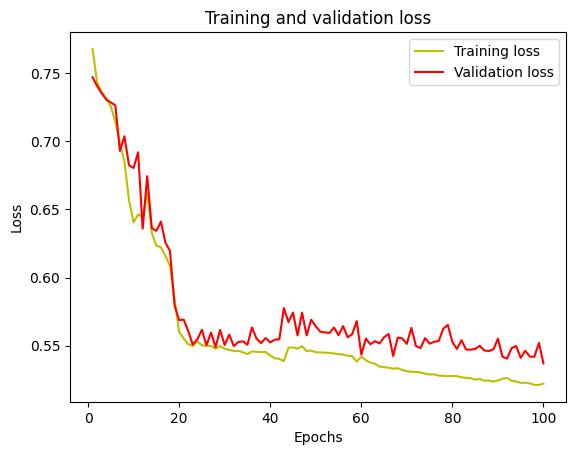

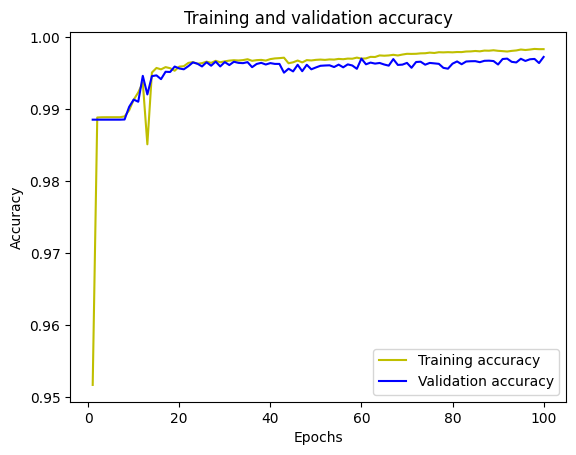

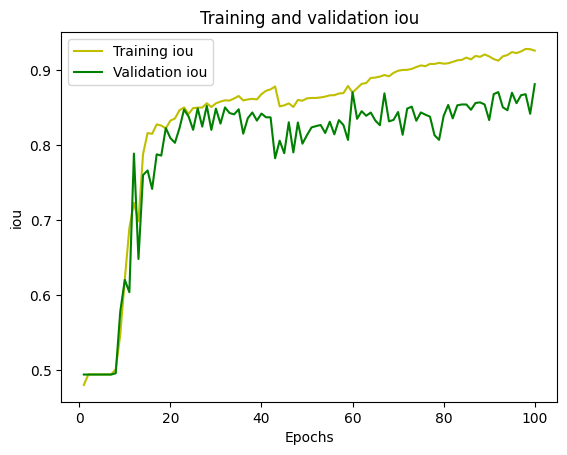

Epoches :  100


In [ ]:
import pandas as pd
csv_file_path = "/content/mouse_segmentation_unet_history.csv"

training_history_dataframe = pd.read_csv(csv_file_path)


##################################################################


#plot the training and validation IoU and loss at each epoch
loss = np.array(training_history_dataframe['loss'])
val_loss = np.array(training_history_dataframe['val_loss'])
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = np.array(training_history_dataframe['accuracy'])
val_acc = np.array(training_history_dataframe['val_accuracy'])

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

iou = np.array(training_history_dataframe['iou_score'])
val_iou = np.array(training_history_dataframe['val_iou_score'])

plt.plot(epochs, iou, 'y', label='Training iou')
plt.plot(epochs, val_iou, 'g', label='Validation iou')
plt.title('Training and validation iou')
plt.xlabel('Epochs')
plt.ylabel('iou')
plt.legend()
plt.show()


print("Epoches : ",len(epochs))
#################################################

**INFERENCE on Validation set**

1/1 [==============================] - 0s 258ms/step
(2, 480, 640, 2)


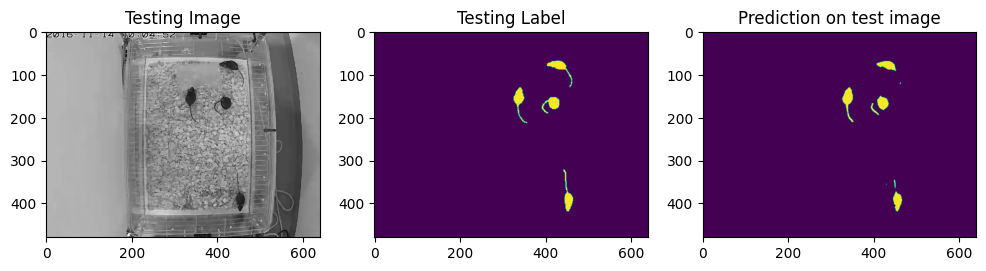

(2, 480, 640, 2)


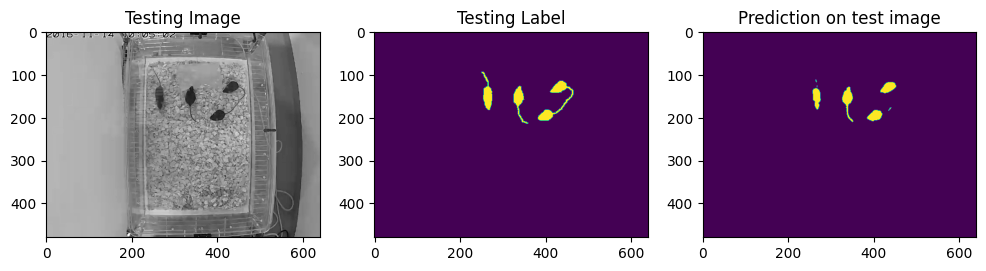

In [ ]:
from keras.models import load_model
Custom_model = load_model('/content/mouse_segmentation_unet.hdf5',
                      compile=False)
X, Y = validation_images_dataGenerator.__next__()
model = Custom_model
prediction = model.predict(X)

for sample_number in range(X.shape[0]):

  ground_truth = Y[sample_number]
  final_ground_truth = np.argmax(ground_truth,axis=2)
  print(prediction.shape)
  final_prediction = np.argmax(prediction,axis=3)[sample_number,:,:]

  new_image = X[sample_number]

  plt.figure(figsize=(12, 8))
  plt.subplot(231)
  plt.title('Testing Image')
  plt.imshow(new_image[:,:,1], cmap='gray')
  plt.subplot(232)
  plt.title('Testing Label')
  plt.imshow(final_ground_truth[:,:])
  plt.subplot(233)
  plt.title('Prediction on test image')
  plt.imshow(final_prediction[:,:])
  plt.show()

  pass

**Calculating Mean IOU of Validation Set**

In [ ]:
test_image_batch, test_mask_batch = validation_images_dataGenerator.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=-1)
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=-1)

n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

1/1 [==============================] - 0s 28ms/step
Mean IoU = 0.88118017
